In [1]:
import os, sys
project_root_dir = os.path.join(os.getcwd(),'../..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)

from matplotlib import pyplot as plt
import numpy as np
from torch import nn
import torch
import config

from utils import show_abundance, plot_endmembers
from HySpecLab.metrics import rmse, sad
from scipy import io as sio

In [2]:
from dataset import Samson

dataset = Samson(config.Samson_PATH)
result_path = os.path.join(config.RESULTS_PATH, 'samson')

# Ground Truth

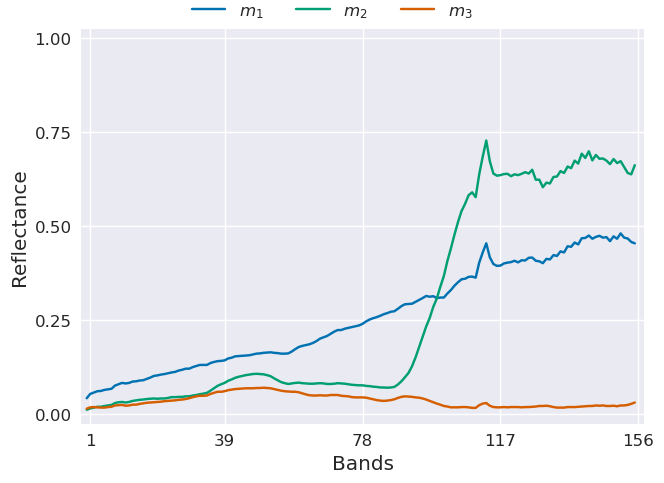

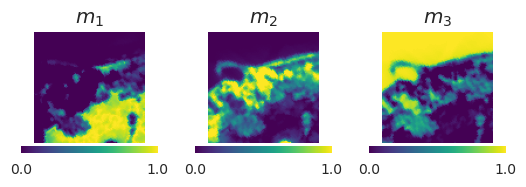

In [3]:
from utils import plot_endmembers, show_abundance
fig = plot_endmembers(dataset.endmembers(), ticks_range=(0, 1))
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'imgs/M_ref.pdf'), bbox_inches='tight')

fig = show_abundance(dataset.abundance())
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'imgs/A_ref.png'), dpi=300, bbox_inches='tight')

In [4]:
from HySpecLab.metrics import sad

def sort_endmember(endmembers, gt):
    sad_result = sad(endmembers, gt)
    e_idx = torch.argmin(sad_result, dim=0) # Index for reordering the ground truth
    return e_idx, sad_result

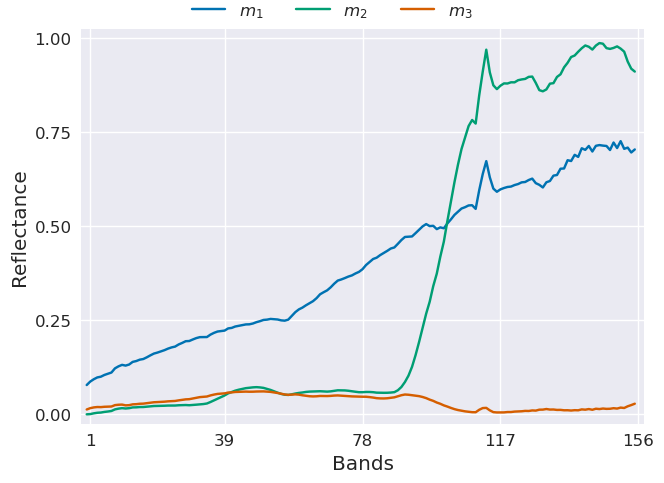

In [5]:
from HySpecLab.eea import VCA

n_endmembers = dataset.n_endmembers
   
vca = VCA(n_endmembers, snr_input=1, random_state=42)
vca.fit(dataset.X.numpy())
endmembers = torch.from_numpy(vca.endmembers()).float()
e_idx, sad_result = sort_endmember(endmembers, dataset.endmembers())

vca_endmember_init = endmembers[e_idx]
vca_logit_endmember_init = torch.log((vca_endmember_init + 1e-12) / ((1-vca_endmember_init) + 1e-12))

fig = plot_endmembers(vca_endmember_init, ticks_range=(0, 1))
plt.show(fig)

# fig.savefig(os.path.join(result_path, 'imgs/M_vca.pdf'), bbox_inches='tight')

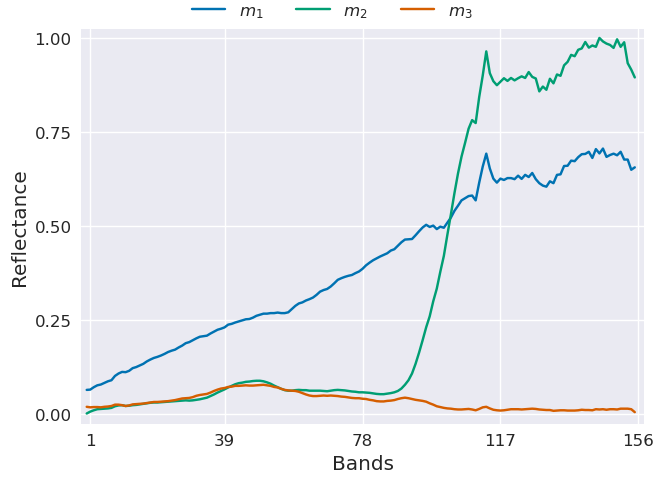

In [6]:
from utils import plot_endmembers
from pysptools import eea
n_endmembers = dataset.n_endmembers 

ee = eea.NFINDR()
endmember = torch.from_numpy(ee.extract(dataset.image(), n_endmembers)).float()

e_idx, _ = sort_endmember(endmember, dataset.endmembers())
nfindr_endmember_init = endmember[e_idx]
nfindr_logit_endmember_init = torch.log((nfindr_endmember_init + 1e-12) / ((1-vca_endmember_init) + 1e-12))

fig = plot_endmembers(nfindr_endmember_init, ticks_range=(0, 1))
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'imgs/M_nfindr.pdf'), bbox_inches='tight')

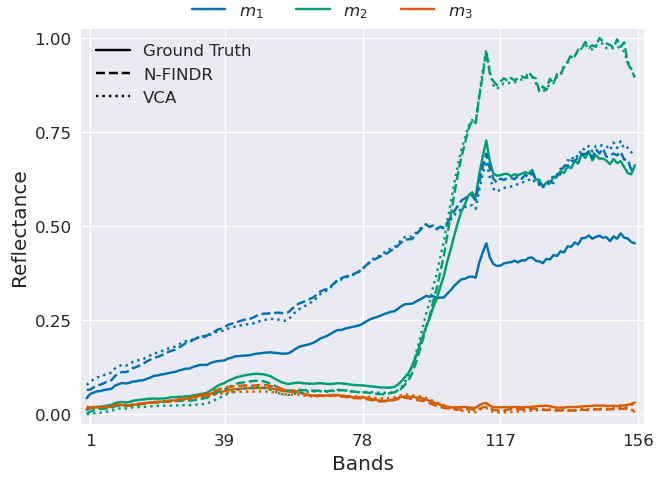

In [7]:
fig = plot_endmembers(dataset.endmembers(), ticks_range=(0, 1), endmember_estimation=[nfindr_endmember_init, vca_endmember_init], ee_labels=['Ground Truth', 'N-FINDR', 'VCA'])
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'imgs/M_estimation.pdf'), bbox_inches='tight')

In [8]:
# endmembers_dict = {'NFINDR': nfindr_endmember_init.numpy(), 'VCA': vca_endmember_init.numpy()}

# sio.savemat(os.path.join(result_path, 'matlab/endmember_estimation.mat'), endmembers_dict)

In [9]:
# endmember_init_method = 'nfindr'
# endmember_init = nfindr_endmember_init
# logit_endmember_init = nfindr_logit_endmember_init

endmember_init_method = 'vca'
endmember_init = vca_endmember_init
logit_endmember_init = vca_logit_endmember_init

# Training

In [51]:
from utils import train 
from HySpecLab.unmixing import ContrastiveUnmixing

n_bands = dataset.n_bands
model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init, sigma_sparsity=.05)
_ = model(dataset.X)
print(model.sparse_gate.regularize().detach())
# train(model, n_endmembers, dataset, n_batchs=50, n_epochs=50, lr=1e-3, simplex_weight=5e-3)
train(model, n_endmembers, dataset, n_batchs=100, n_epochs=100, lr=1e-3, similarity_weight=1, sparse_weight=0)

tensor(1.0000)


  0%|          | 0/100 [00:00<?, ?epoch/s, tls=-1.0000]

In [52]:
# model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init, sigma_sparsity=.1)
model.eval()
z = model.encoder(dataset.X.cuda())
model.sparse_gate(z).mean()

tensor(0.7125, device='cuda:0', grad_fn=<MeanBackward0>)

In [53]:
model.eval()
_ = model(dataset.X.cuda())
print(model.sparse_gate.variational_parameter().flatten())
print(model.sparse_gate.variational_parameter().flatten().mean())
print(model.sparse_gate.variational_parameter().flatten().min())
print(model.sparse_gate.regularize())

tensor([0.2287, 0.2075, 0.2084,  ..., 0.9617, 0.9711, 0.9804], device='cuda:0',
       grad_fn=<ReshapeAliasBackward0>)
tensor(0.7125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2075, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.9947, device='cuda:0', grad_fn=<MeanBackward0>)


# Save model

In [54]:
# torch.save(model.state_dict(), os.path.join(result_path, f'clhu/weights/clhu_{endmember_init_method}.pth'))

# Testing model

In [55]:
# from HySpecLab.unmixing import ContrastiveUnmixing

# load model
# model = ContrastiveUnmixing(dataset.n_bands, dataset.n_endmembers)

# model.load_state_dict(torch.load(os.path.join(result_path, 'clhu/weights/clhu.pth')))
model = model.eval()

In [56]:
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss
from HySpecLab.metrics import UnmixingLoss, NormalizedEntropy

criterion = UnmixingLoss()
entropy_reg  = NormalizedEntropy(S=n_endmembers)
volume_reg = SimplexVolumeLoss(dataset[:], n_endmembers)
similarity_reg = SimilarityLoss(n_endmembers, temperature=.1, reduction='mean')

In [57]:
from torch import sigmoid 
_X = dataset.X

model.eval()
model = model.cpu()
reconstruc = model(_X)
with torch.no_grad():
    print(criterion(reconstruc, _X).cpu(), entropy_reg(model.A).cpu(), volume_reg(sigmoid(model.ebk)).cpu(),
         similarity_reg(model.ebk).cpu())
        #  similarity_reg(sigmoid(model.ebk)).cpu())

tensor(0.0078) tensor(0.5691) tensor(264.9899) tensor(0.0010)


In [58]:
volume_reg(endmember_init), similarity_reg(logit_endmember_init)

(tensor(59.2881), tensor(0.1501))

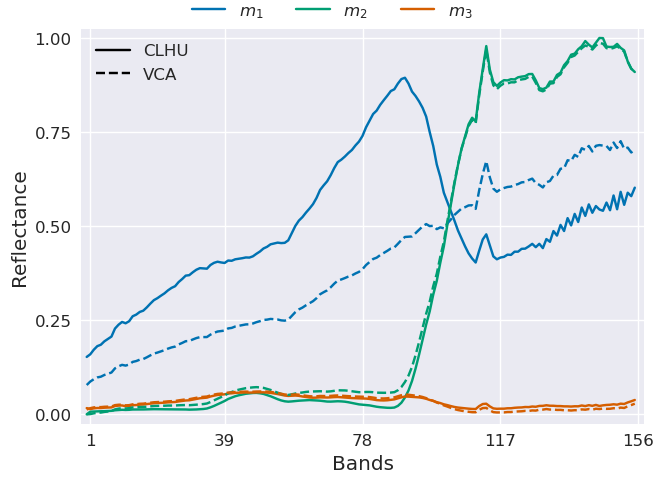

In [60]:
ebk = torch.sigmoid(model.ebk).detach().cpu()
if endmember_init_method == 'vca':
    label = 'VCA'
else:
    label = 'N-FINDR'
fig = plot_endmembers(ebk, ticks_range=(0, 1), endmember_estimation=[endmember_init], ee_labels=['CLHU',label])
plt.show(fig)
# fig.savefig(os.path.join(result_path, f'clhu/imgs/M_clhu_{endmember_init_method}.pdf'), bbox_inches='tight')

# fig = plot_endmembers(ebk, ticks_range=(0, 1))
# plt.show(fig)
# fig.savefig(os.path.join(result_path, 'clhu/imgs/M_clhu_2.pdf'), bbox_inches='tight')

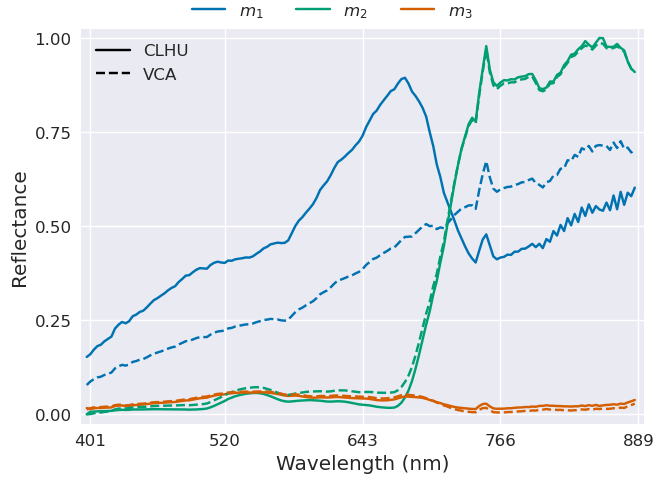

In [62]:
fig = plot_endmembers(ebk, dataset.wv, ticks_range=(0, 1), endmember_estimation=[endmember_init], ee_labels=['CLHU',label])
plt.show(fig)

sio.savemat('/media/abian/Extreme SSD/Thesis/CLHU/review/EndmemberInsigth/samson.mat', {'ebk': ebk.numpy()})
fig.savefig('/media/abian/Extreme SSD/Thesis/CLHU/review/EndmemberInsigth/samson_M.pdf', bbox_inches='tight')

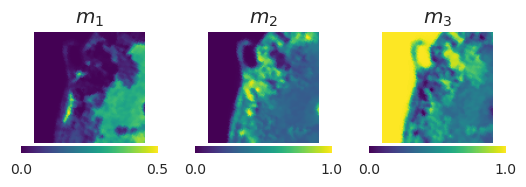

In [65]:
from torch.nn.functional import softmax
test = softmax(model.A.detach(), dim=1).cpu().numpy().reshape(dataset.n_row, dataset.n_col, -1)

fig = show_abundance(test, transpose=False, cmap='viridis')
plt.show(fig)

# fig.savefig(os.path.join(result_path, f'clhu/imgs/A_clhu_estimation_{endmember_init_method}.pdf'), dpi=300, bbox_inches='tight')
fig.savefig('/media/abian/Extreme SSD/Thesis/CLHU/review/EndmemberInsigth/samson_A.pdf', bbox_inches='tight')

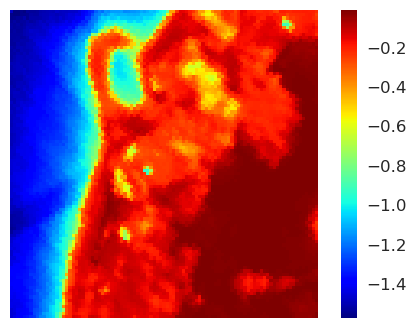

In [66]:
sparse = model.sparse_gate.variational_parameter().detach().cpu().numpy().reshape(dataset.n_row, dataset.n_col)
sparse = np.log(sparse)
fig, ax = plt.subplots(figsize=(6,4))
im = ax.imshow(sparse, cmap='jet')
cbar = plt.colorbar(im)
# cbar.set_label(r'$\log(\rho)$', labelpad=2, fontsize=14)
cbar.ax.tick_params(labelsize=12)
plt.axis('off')
# plt.savefig(os.path.join(result_path, f'clhu/imgs/sparse_clhu_estimation_{endmember_init_method}.pdf'), bbox_inches='tight')
fig.savefig('/media/abian/Extreme SSD/Thesis/CLHU/review/EndmemberInsigth/samson_sparse.pdf', bbox_inches='tight')
plt.show(fig)
plt.close(fig)

In [67]:
model.eval()
X_true = dataset.A @ dataset.endmembers()
# X_true = dataset.X
X_hat = model(dataset.X).detach().cpu()
A_hat = torch.softmax(model.A.detach().cpu(), dim=1)
M_hat = sigmoid(model.ebk.detach().cpu())

real_M_hat = model(M_hat).detach().cpu()

import pandas as pd
df = pd.DataFrame(columns=['Method', 'RMSE_X', 'RMSE_A', 'SAD_M'])
df['Method'] = ['CLHU']
df['RMSE_X'] = [rmse(X_true, X_hat, dim=None).numpy()]
df['RMSE_A'] = [rmse(dataset.A, A_hat, dim=None).numpy()]

sad_result = sad(M_hat, dataset.endmembers()).numpy()
# sad_result = sad(_M_hat, dataset.endmembers()).numpy()

df['SAD_M'] = np.diagonal(sad_result).mean()

# df.to_csv(os.path.join(result_path, 'clhu/metrics.csv'), index=False)
print(np.diagonal(sad(real_M_hat, dataset.endmembers()).numpy()).mean())
real_M_hat2 = model(real_M_hat).detach()
print(np.diagonal(sad(real_M_hat2, dataset.endmembers()).numpy()).mean())
df

0.122538485
0.0959846


,Method,RMSE_X,RMSE_A,SAD_M
0,CLHU,0.022686986,0.24091236,0.219489


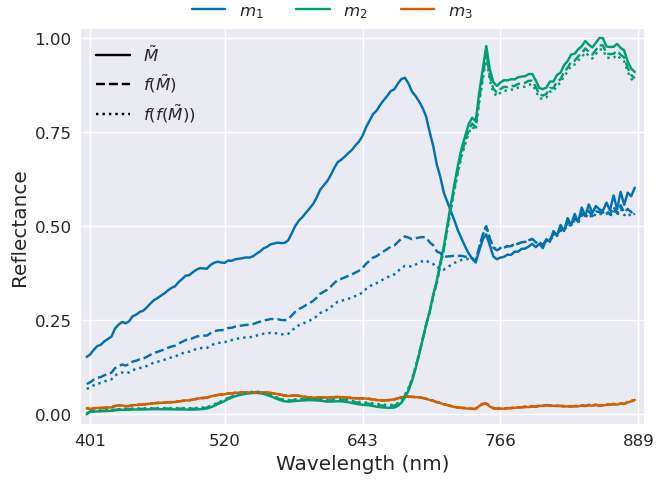

In [80]:
M_hat = sigmoid(model.ebk.detach().cpu())
real_M_hat = model(M_hat).detach().cpu()
real_M_hat2 = model(real_M_hat).detach()

sad_M = np.diagonal(sad(M_hat, dataset.endmembers()).numpy()).mean()
sad_M_hat = np.diagonal(sad(real_M_hat, dataset.endmembers()).numpy()).mean()
sad_M_hat2 = np.diagonal(sad(real_M_hat2, dataset.endmembers()).numpy()).mean()

sad_df = pd.DataFrame(columns=['SAD_M', 'SAD_M_hat', 'SAD_M_hat2'])
sad_df['SAD_M'] = [sad_M]
sad_df['SAD_M_hat'] = [sad_M_hat]
sad_df['SAD_M_hat2'] = [sad_M_hat2]
sad_df.to_csv('/media/abian/Extreme SSD/Thesis/CLHU/review/EndmemberInsigth/samson_sad.csv', index=False)

fig = plot_endmembers(M_hat, dataset.wv, ticks_range=(0, 1), endmember_estimation=[real_M_hat, real_M_hat2], ee_labels=[r'$\tilde{M}$',r'$f(\tilde{M})$', r'$f(f(\tilde{M}))$'])
plt.show(fig)
fig.savefig('/media/abian/Extreme SSD/Thesis/CLHU/review/EndmemberInsigth/samson_M_reconstruction.pdf', bbox_inches='tight')

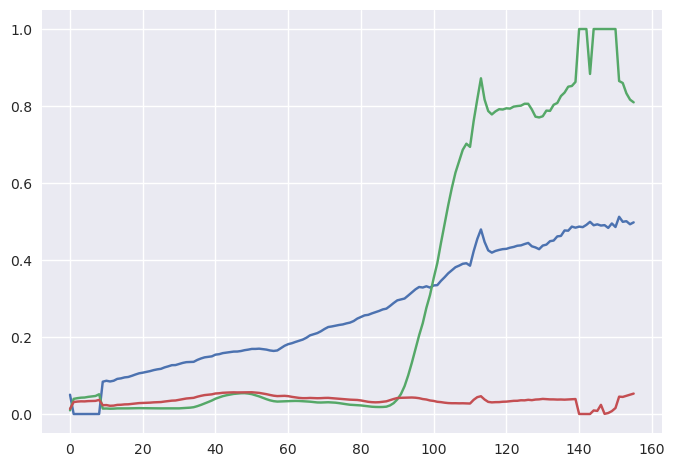

In [51]:
_M_hat = torch.sigmoid(model.ebk.cpu()).detach()
plt.plot(_M_hat.T)
plt.show()

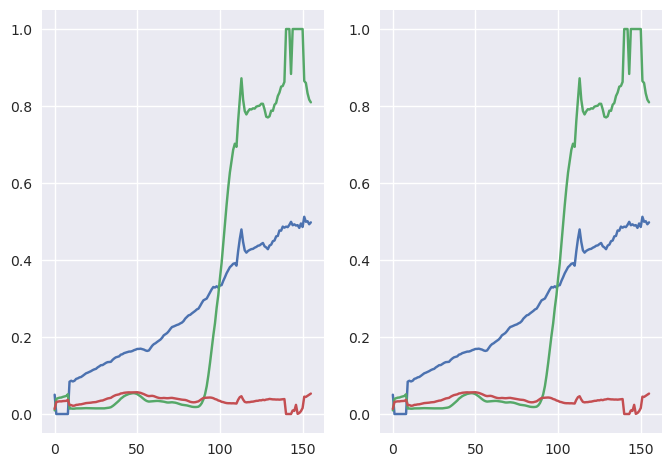

In [52]:
plt.subplot(1,2,1)
plt.plot(M_hat.detach().cpu().numpy().T)
plt.subplot(1,2,2)
plt.plot(_M_hat.detach().cpu().numpy().T)
plt.show()

# ...

In [53]:
from HySpecLab.metrics import rmse
from torch import sigmoid
def test(model, dataset):
    X = dataset.X
    model.eval()
    model = model.cpu()
    
    X_true = dataset.A @ dataset.endmembers()
    with torch.no_grad():
        X_hat = model(dataset.X)
        A_hat = torch.softmax(model.A, dim=1)
        M_hat = sigmoid(model.ebk) 
    
    rmse_x = rmse(X_true, X_hat, dim=None).numpy()      
    rmse_a = rmse(dataset.A, A_hat, dim=None).numpy()
    sad_m = np.diagonal(sad(M_hat, dataset.endmembers()).numpy()).mean()
    return rmse_x.item(), rmse_a.item(), sad_m

In [54]:
from HySpecLab.unmixing import ContrastiveUnmixing

n_bands = dataset.n_bands

batch_rmse_x = []
batch_rmse_a = []
batch_sad_m = []
for i in range(10):
    model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init, sigma_sparsity=.5)
    train(model, n_endmembers, dataset, n_batchs=100, n_epochs=100, lr=1e-3, similarity_weight=1, sparse_weight=.25)

    rmse_x, rmse_a, sad_m = test(model, dataset)
    batch_rmse_x.append(rmse_x)
    batch_rmse_a.append(rmse_a)
    batch_sad_m.append(sad_m)

    print(rmse_x, rmse_a, sad_m)

  0%|          | 0/100 [00:00<?, ?epoch/s, tls=-1.0000]

100%|██████████| 100/100 [00:29<00:00,  3.43epoch/s, tls=0.3717]


0.02829718217253685 0.1559564471244812 0.1906724


100%|██████████| 100/100 [00:29<00:00,  3.42epoch/s, tls=0.3047]


0.022307833656668663 0.18001295626163483 0.17550956


100%|██████████| 100/100 [00:29<00:00,  3.37epoch/s, tls=0.3013]


0.02413681149482727 0.18268702924251556 0.17956918


100%|██████████| 100/100 [00:28<00:00,  3.47epoch/s, tls=0.3602]


0.025195984169840813 0.1430131047964096 0.17668194


100%|██████████| 100/100 [00:29<00:00,  3.43epoch/s, tls=0.3110]


0.026710789650678635 0.14695346355438232 0.17017531


100%|██████████| 100/100 [00:29<00:00,  3.42epoch/s, tls=0.3619]


0.027294766157865524 0.16813775897026062 0.2081977


100%|██████████| 100/100 [00:29<00:00,  3.44epoch/s, tls=0.3638]


0.027752362191677094 0.12560461461544037 0.17472024


100%|██████████| 100/100 [00:29<00:00,  3.41epoch/s, tls=0.3237]


0.02712540701031685 0.12986841797828674 0.16947637


100%|██████████| 100/100 [00:28<00:00,  3.45epoch/s, tls=0.3228]


0.025130556896328926 0.13801467418670654 0.16419132


100%|██████████| 100/100 [00:29<00:00,  3.41epoch/s, tls=0.3546]

0.027278780937194824 0.15408873558044434 0.20126075


In [55]:
# generate dataframe
import pandas as pd
df = pd.DataFrame(columns=['RMSE_X', 'RMSE_A', 'SAD_M'])
df['RMSE_X'] = batch_rmse_x
df['RMSE_A'] = batch_rmse_a
df['SAD_M'] = batch_sad_m

# extract mean and std
df['RMSE_X'].mean(), df['RMSE_X'].std(), df['RMSE_A'].mean(), df['RMSE_A'].std(), df['SAD_M'].mean(), df['SAD_M'].std()

(0.026123047433793546,
 0.0018792969107438331,
 0.15243372023105622,
 0.01970145609565032,
 0.18104549,
 0.014401079155504704)

In [56]:
df.to_csv(os.path.join(result_path, 'clhu/metrics_{}_batch.csv'.format(endmember_init_method)), index=False)